In [1]:
import os
import re
import statistics
from src.najdi_rok import najdi_rok
from src.pocet_stran import pocet_stran
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [2]:
df = pd.read_parquet(os.path.join("data","cnb_vyber.parquet"))
df['rok'] = df['008'].apply(lambda x: najdi_rok(x))
df['pocet_stran'] = df['300_a'].apply(lambda x: pocet_stran(x))

In [4]:
df['pocet_stran'].quantile([0.1,0.25,0.5,0.75,0.9])

0.10     20.0
0.25     52.0
0.50    120.0
0.75    220.0
0.90    335.0
Name: pocet_stran, dtype: float64

In [5]:
nemala = df['pocet_stran'].quantile(0.25)
nemala

52.0

In [6]:
df = df[df['pocet_stran'] >= nemala]

In [7]:
explo041 = df.explode('041_h')
preklady = explo041[(explo041['041_h'].notnull()) & (explo041['041_h'] != 'cze')]

## Podíl překladové literatury (spíš v datech než v realitě)

<Axes: xlabel='rok'>

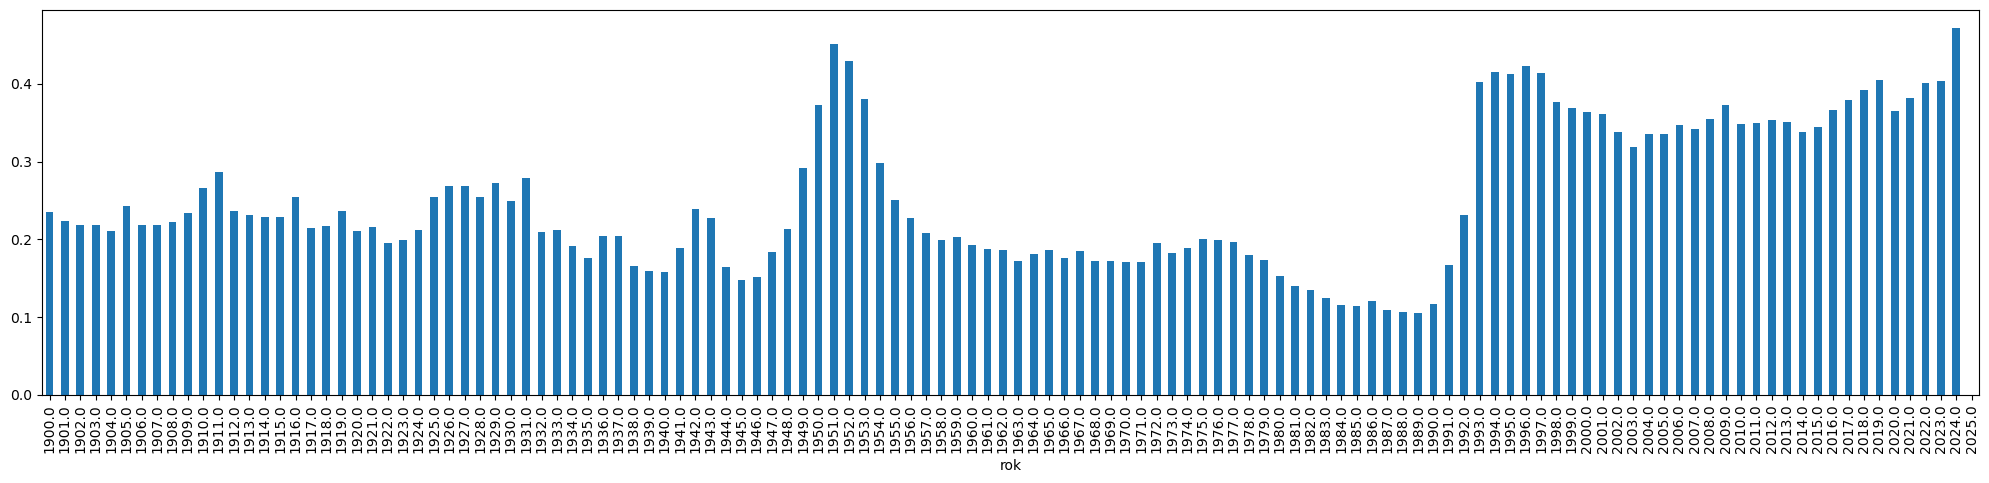

In [12]:
(preklady.groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

In [14]:
(preklady.groupby('rok').size() / df.groupby('rok').size()).nlargest(20)

rok
2024.0    0.471499
1951.0    0.451720
1952.0    0.429528
1996.0    0.423612
1994.0    0.414944
1997.0    0.413571
1995.0    0.412966
2019.0    0.404729
2023.0    0.404058
1993.0    0.402648
2022.0    0.401428
2018.0    0.391858
2021.0    0.381287
1953.0    0.380469
2017.0    0.379809
1998.0    0.376382
2009.0    0.373218
1950.0    0.372701
1999.0    0.369350
2016.0    0.366230
dtype: float64

<Axes: xlabel='rok'>

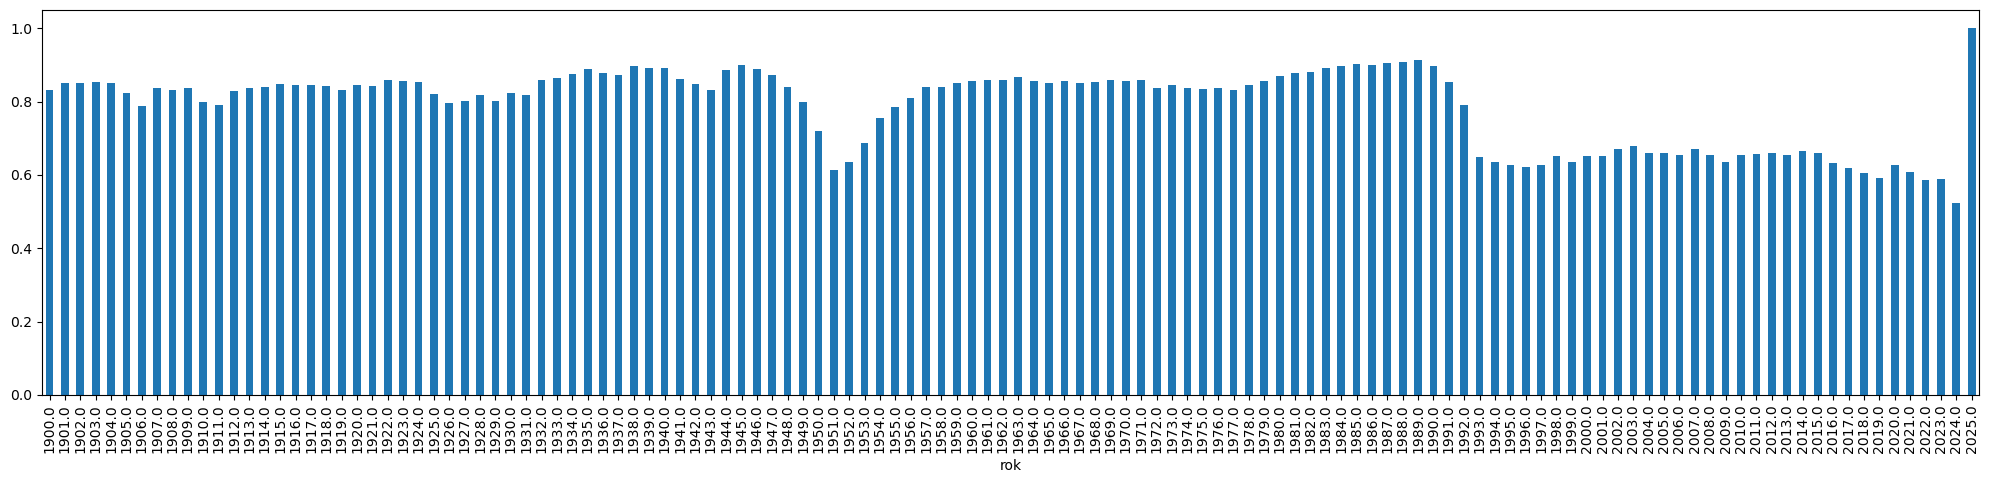

In [12]:
(explo041[explo041['041_h'].isnull()].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

<Axes: xlabel='rok'>

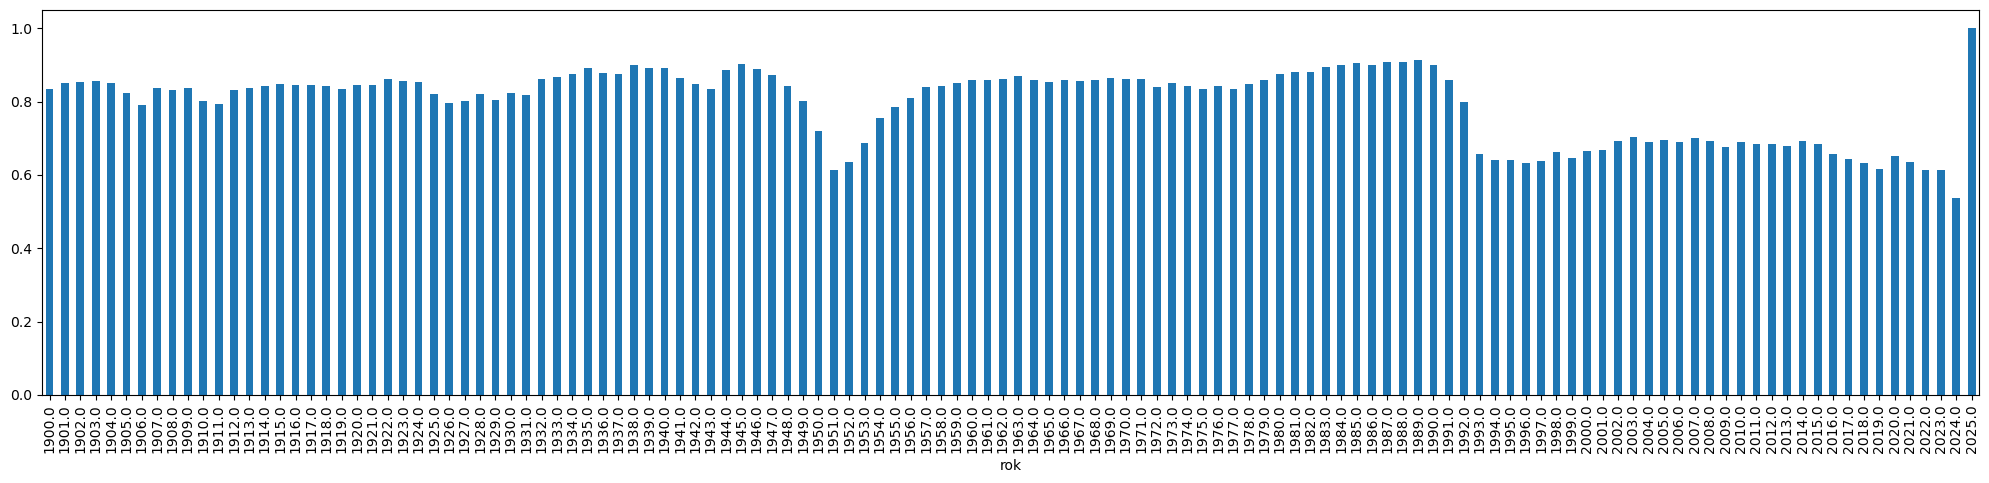

In [14]:
(~explo041[explo041['041_h'].isnull() | (~explo041['041_h'] == 'cze')].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

## Top jazyky

In [23]:
preklady.groupby('041_h').size().nlargest(40)

041_h
eng    82791
ger    36207
rus    17519
fre    14742
slo     3902
pol     3762
ita     3581
und     2628
spa     2468
lat     1712
swe     1647
mul     1632
dut     1109
hun     1036
nor      954
grc      883
dan      786
jpn      605
bul      535
chi      492
heb      465
fin      411
sla      389
scr      374
ukr      369
por      347
slv      341
rum      277
gre      170
ice      159
ara      156
arc      150
hrv      145
srp      137
san      120
kor      110
est       91
ben       74
tib       74
lav       72
dtype: int64

In [90]:
jazyky = {'eng': 'angličtina', 'ger': 'němčina', 'rus': 'ruština', 'fre': 'francouzština', 'pol': 'polština', 'ita': 'italština', 'slo': 'slovenština', 'spa': 'španělština', 'lat': 'latina', 'swe': 'švédština', 'dut': 'nizozemština', 'hun': 'madarština', 'nor': 'norština','grc':'řečtina','dan':'dánština','jpn':'japonština','bul':'bulharština','chi':'čínština','heb':'hebrejština','fin':'finština'}

In [94]:
top = preklady.groupby('041_h').size().nlargest(20).index.to_list()
top = [t for t in top if t in jazyky.keys()]
print(len(top))
top

18


['eng',
 'ger',
 'rus',
 'fre',
 'slo',
 'pol',
 'ita',
 'spa',
 'lat',
 'swe',
 'dut',
 'hun',
 'nor',
 'grc',
 'dan',
 'jpn',
 'bul',
 'chi']

In [74]:
preklady.groupby('041_h')['rok'].nunique().nlargest(20)

041_h
eng    125
ger    125
ita    125
dan    124
fre    124
lat    124
rus    124
grc    122
pol    121
spa    121
hun    120
nor    118
swe    118
und    116
dut    110
mul    109
slo    104
slv     99
scr     96
bul     93
Name: rok, dtype: int64

In [98]:
top_serie = []
for t in top:
    top_serie.append(pd.Series( preklady[preklady['041_h'] == t].groupby('rok').size() / preklady.groupby('rok').size(), name=jazyky[t]))

japonština


<Axes: xlabel='rok'>

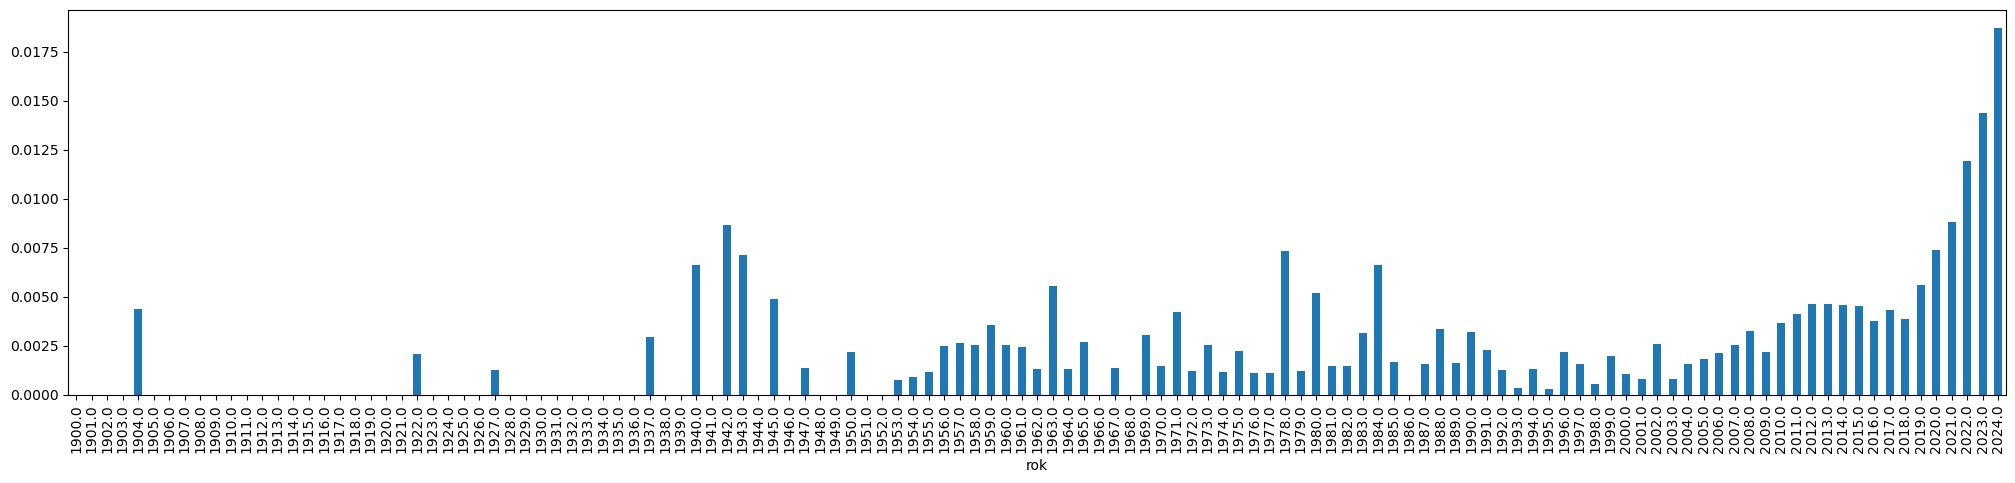

In [112]:
print(top_serie[15].name)
top_serie[15].plot.bar(figsize=(25,5))

## Variabilita / rozptyl

In [100]:
variabilita = {}
for t in top_serie:
    variabilita[t.name] = t.var()
pd.Series(variabilita).sort_values()

čínština         0.000008
japonština       0.000010
nizozemština     0.000029
řečtina          0.000039
španělština      0.000039
švédština        0.000043
dánština         0.000054
madarština       0.000057
norština         0.000060
bulharština      0.000064
latina           0.000124
italština        0.000181
polština         0.000486
slovenština      0.001365
francouzština    0.007431
němčina          0.013736
ruština          0.032543
angličtina       0.036107
dtype: float64